In [86]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import scipy
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
from scipy.ndimage import imread
from scipy.misc import imsave
from PIL import Image
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [13]:
IMGDIR = '../../data/VOCdevkit'
DATADIR = '/home/ubuntu/SSDcaffe/data/VOC0712'
TESTDIR = '../data/Test'

In [10]:
trn_imgs = os.listdir(os.path.join(IMGDIR, "VOC0712/JPEGImages"))
trn_annos = os.listdir(os.path.join(IMGDIR, "VOC0712/Annotations"))
print( len(trn_imgs), len(trn_annos))
trn_annos[:2]

(45434, 7198)


['187_71.xml', '200_23.xml']

In [14]:
os.path.join(DATADIR, 'trainval_fold1.csv')

'/home/ubuntu/SSDcaffe/data/VOC0712/trainval_fold1.csv'

### Write out train and test files

In [44]:
tv_fold1 = open(os.path.join(DATADIR, 'trainval_fold1.txt'),'w')
for f in trn_annos:
    fname = f.split('.')[0]
    imgname = f.split('_')[0]
    if int(imgname) % 2 == 0 :
        tv_fold1.write('VOC0712/JPEGImages/%s.jpg VOC0712/Annotations/%s.xml\n'%(fname, fname))
tv_fold1.close()

tv_fold2 = open(os.path.join(DATADIR, 'trainval_fold2.txt'),'w')
for f in trn_annos:
    fname = f.split('.')[0]
    imgname = f.split('_')[0]
    if int(imgname) % 2 != 0 :
        tv_fold2.write('VOC0712/JPEGImages/%s.jpg VOC0712/Annotations/%s.xml\n'%(fname, fname))
tv_fold2.close()

ts_fold1 = open(os.path.join(DATADIR, 'test_fold1.txt'),'w')
for f in trn_annos:
    fname = f.split('.')[0]
    imgname = f.split('_')[0]
    if int(imgname) % 2 != 0 :
        ts_fold1.write('VOC0712/JPEGImages/%s.jpg VOC0712/Annotations/%s.xml\n'%(fname, fname))
ts_fold1.close()

ts_fold2 = open(os.path.join(DATADIR, 'test_fold2.txt'),'w')
for f in trn_annos:
    fname = f.split('.')[0]
    imgname = f.split('_')[0]
    if int(imgname) % 2 == 0 :
        ts_fold2.write('VOC0712/JPEGImages/%s.jpg VOC0712/Annotations/%s.xml\n'%(fname, fname))
ts_fold2.close()

### Write out image sizes

In [45]:
ts_sz_fold2 = open(os.path.join(DATADIR, 'test_name_size_fold2.txt'),'w')
for f in trn_annos:
    fname = f.split('.')[0]
    imgname = f.split('_')[0]
    if int(imgname) % 2 == 0 :
        shp = imread('/home/ubuntu/data/VOCdevkit/VOC0712/JPEGImages/%s.jpg'%(fname)).shape
        ts_sz_fold2.write('%s %s %s\n'%(fname, shp[0], shp[1]))
ts_sz_fold2.close()

ts_sz_fold1 = open(os.path.join(DATADIR, 'test_name_size_fold1.txt'),'w')
for f in trn_annos:
    fname = f.split('.')[0]
    imgname = f.split('_')[0]
    if int(imgname) % 2 != 0 :
        shp = imread('/home/ubuntu/data/VOCdevkit/VOC0712/JPEGImages/%s.jpg'%(fname)).shape
        ts_sz_fold1.write('%s %s %s\n'%(fname, shp[0], shp[1]))
ts_sz_fold1.close()

### Copy the annotations and images and replace annotations with ints for SSD

In [47]:
# Copy the directories
dir_from = "/home/ubuntu/py-R-FCN/data/VOCdevkit0712/VOC0712/"
dir_to = "/home/ubuntu/data/VOCdevkit/VOC0712"
import shutil
shutil.copytree(dir_from, dir_to)

In [56]:
# Replace floats with int in annotations
#!/usr/bin/env python3
import fileinput
textToSearch1 = ['.0</xmin>', '.0</ymin>', '.0</xmax>', '.0</ymax>']
textToSearch2 = ['.1</xmin>', '.1</ymin>', '.1</xmax>', '.1</ymax>']
textToSearch3 = ['.9</xmin>', '.9</ymin>', '.9</xmax>', '.9</ymax>']
textToReplace = ['</xmin>', '</ymin>', '</xmax>', '</ymax>']
trn_annos[:2]

['187_71.xml', '200_23.xml']

In [57]:
dir_from = "/home/ubuntu/py-R-FCN/data/VOCdevkit0712/VOC0712/"
dir_to = "/home/ubuntu/data/VOCdevkit/VOC0712"
for f in trn_annos:
    fname = os.path.join(dir_to, "Annotations", f)
    # Read in the file
    with open(fname, 'r') as file :
      filedata = file.read()
    
    for i in range(4):
        filedata = filedata.replace(textToSearch1[i], textToReplace[i])
        filedata = filedata.replace(textToSearch2[i], textToReplace[i])
        filedata = filedata.replace(textToSearch3[i], textToReplace[i])

    filedata = filedata.replace('<folder>seals</folder>', '<folder>VOC0712</folder>')

        
    # Write the file out again
    with open(fname, 'w') as file:
      file.write(filedata)

In [76]:
import xmltodict
with open(os.path.join(dir_to, "Annotations", trn_annos[0])) as fd:
    doc = xmltodict.parse(fd.read())

In [82]:
print doc['annotation']['filename']
for seg in doc['annotation']['object'][:2]:
    print seg['name']
    print seg['bndbox']


187_71.jpg
seals
OrderedDict([(u'xmin', u'0'), (u'ymin', u'153'), (u'xmax', u'43'), (u'ymax', u'203')])
0
seals
OrderedDict([(u'xmin', u'12'), (u'ymin', u'190'), (u'xmax', u'62'), (u'ymax', u'240')])
12
seals
OrderedDict([(u'xmin', u'13'), (u'ymin', u'464'), (u'xmax', u'63'), (u'ymax', u'514')])
13


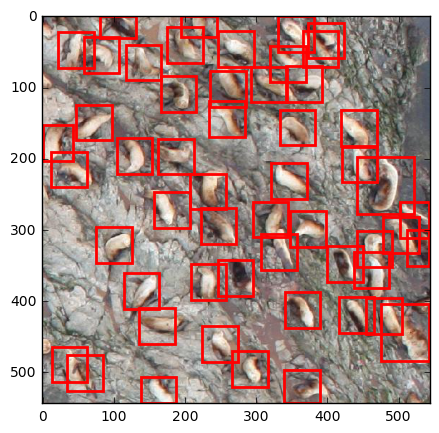

In [89]:
def create_rect2(row):
    return plt.Rectangle((row[0], row[1]), row[2] - row[0], row[3] - row[1], color='red', fill=False, lw=2)
img = imread('/home/ubuntu/data/VOCdevkit/VOC0712/JPEGImages/%s'%(doc['annotation']['filename']))
plt.figure(figsize=(5,5))
plt.imshow(img)
for seg in doc['annotation']['object']:
    row = [seg['bndbox']['xmin'], seg['bndbox']['ymin'], seg['bndbox']['xmax'], seg['bndbox']['ymax']]
    row = [int(i) for i in row]
    plt.gca().add_patch(create_rect2(row))


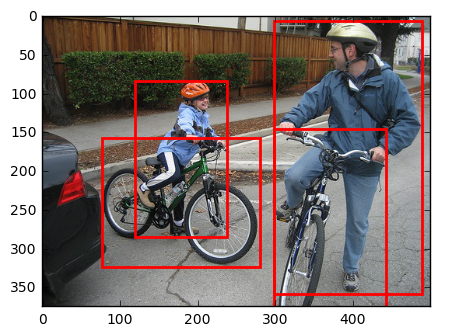

In [109]:
import xmltodict

with open(os.path.join("/home/ubuntu/data/VOCdevkit/VOC2007_orig/Annotations/009926.xml")) as fd:
    doc = xmltodict.parse(fd.read())
img = imread('/home/ubuntu/data/VOCdevkit/VOC2007_orig/JPEGImages/%s'%(doc['annotation']['filename']))
plt.figure(figsize=(5,5))
plt.imshow(img)
for seg in doc['annotation']['object']:
    row = [seg['bndbox']['xmin'], seg['bndbox']['ymin'], seg['bndbox']['xmax'], seg['bndbox']['ymax']]
    row = [int(i) for i in row]
    plt.gca().add_patch(create_rect2(row))